In [ ]:
#%pip install -r requirements.txt

In [1]:
import os
from typing import Dict, TypedDict
from dotenv import load_dotenv
from datetime import datetime, timedelta
import requests
import json
import pandas as pd
import numpy as np
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel

FINANCIAL_API_KEY=os.getenv("FINANCIAL_API_KEY")
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")
OPENAI_BASE_URL=os.getenv("OPENAI_BASE_URL")

In [2]:
class FinancialDataLoader:
    """Financial data loader compatible with the latest API specifications of FinancialDatasets.ai"""
    
    # Basic configuration can be modified through environment variables
    BASE_URL = "https://api.financialdatasets.ai"
    
    def __init__(self, api_key: str = FINANCIAL_API_KEY):
        self._api_key = api_key

    def _make_request(self, endpoint: str, params: Dict = None) -> Dict:
        headers = {
            "X-API-KEY": FINANCIAL_API_KEY
        }
        
        response = requests.get(
            f"https://api.financialdatasets.ai/{endpoint}",
            headers=headers,
            params=params,
        )
        response.raise_for_status()  # Automatically raise HTTP errors
        
        return response.json()  # Assuming the return structure contains a data field
    # Fetch historical market data (DONE)
    def fetch_market_data(
        self, 
        symbol: str,
        interval: str = "day",
        days: int = 54,
        )-> Dict:

        url = "https://api.financialdatasets.ai/prices"
        
        params = {
            "ticker": symbol.upper(),
            "interval": interval,
            "start_date": (datetime.now() - timedelta(days=days)).strftime("%Y-%m-%d"),
            "end_date": datetime.now().strftime("%Y-%m-%d"),
            "interval_multiplier":"1"
        }

        headers = {
            "X-API-KEY": FINANCIAL_API_KEY
        }

        raw_data = requests.request("GET", url, headers=headers, params=params)
        return raw_data.json()
    
    # Fetch fundamental data (DONE)
    def fetch_fundamental_data(self, symbol: str) -> Dict:
        return self._make_request(f"financials?period=quarterly&ticker={symbol.upper()}")
    # Fetch sentiment data (DONE)
    def fetch_sentiment_data(self, symbol: str) -> Dict:
        return self._make_request(f"news?ticker={symbol.upper()}")
    # Fetch snapshot data (DONE)
    def fetch_snapshot_data(self, symbol: str) -> Dict:
        return self._make_request(f"prices/snapshot?ticker={symbol.upper()}")

'\nsymbol = "AAPL"\nloader = FinancialDataLoader()\nmarket_data = loader.fetch_market_data(\n            symbol=symbol,\n            interval="minute", \n            days=45,\n            interval_multiplier=1\n        )\n#fundamental_data = loader.fetch_fundamental_data(symbol)\n#sentiment_data = loader.fetch_sentiment_data(symbol)\n#snapshot_data = loader.fetch_snapshot_data(symbol)\n'

In [3]:
class AnalysisState(TypedDict):
    symbol: str
    market_data: pd.DataFrame
    fundamental_data: dict
    sentiment_data: dict
    risk_data: pd.DataFrame
    quant_signals: dict
    fundamental_analysis: str
    sentiment_analysis: str
    risk_analysis: str
    portfolio_suggestion: dict

In [4]:
class QuantAnalystAgent:
    
    def __init__(self):
        """self.llm = ChatOpenAI(
            temperature=0,
            model="gpt-4o-mini",
            max_retries=3
        )"""
        
        
    def _calculate_technical_indicators(self, df: pd.DataFrame) -> dict:

        closes = df['close'].values
        highs = df['high'].values
        lows = df['low'].values
        
        # RSI
        delta = closes[1:] - closes[:-1]
        gain = delta.copy()
        gain[gain < 0] = 0
        loss = -delta.copy()
        loss[loss < 0] = 0
        avg_gain = np.mean(gain[:14])
        avg_loss = np.mean(loss[:14])
        rsi = 100 - (100 / (1 + avg_gain/avg_loss))
        
        return {
            "Close":closes[-1],
            "High":highs[-1],
            "Low":lows[-1],
            "Delta": delta,
            "avg_gain": avg_gain,
            "avg_loss": avg_loss,
            "RSI_14": rsi,
        }
    
    def __call__(self, state: AnalysisState) -> Dict:
        indicators = self._calculate_technical_indicators(state['market_data'])
        return {"quant_signals": indicators}


''' Usage
        state = AnalysisState(
            symbol="AAPL",
            market_data=pd.DataFrame(market_data['prices']),
            fundamental_data=fundamental_data,
            sentiment_data=sentiment_data,
            quant_signals={},
            fundamental_analysis="",
            sentiment_analysis="",
            risk_analysis={},
            portfolio_suggestion={}
        )

        agent = QuantAnalystAgent()
        result = agent(state)
        print(result)
'''

' Usage\n        state = AnalysisState(\n            symbol="AAPL",\n            market_data=pd.DataFrame(market_data[\'prices\']),\n            fundamental_data=fundamental_data,\n            sentiment_data=sentiment_data,\n            quant_signals={},\n            fundamental_analysis="",\n            sentiment_analysis="",\n            risk_analysis={},\n            portfolio_suggestion={}\n        )\n\n        agent = QuantAnalystAgent()\n        result = agent(state)\n        print(result)\n'

In [5]:
class FundamentalAnalystAgent:
    
    
    def __init__(self):
        self.llm = ChatOpenAI(
            temperature=0.2,
            model= "gpt-4o-mini",
            request_timeout=30  
            
        )
        
    

    def analyze_valuation(self, data: dict) -> str:
        income = data['financials']['income_statements']
        balance = data['financials']['balance_sheets']
        cashflow = data['financials']['cash_flow_statements']
        current_price = data['snapshot']['snapshot']['price']
        eps = income[0]['net_income_common_stock'] / balance[0]['outstanding_shares']
        pe_ratio = current_price / eps

        market_cap = current_price * balance[0]['outstanding_shares']
        pb_ratio = market_cap / balance[0]['shareholders_equity']

        ev = market_cap + balance[0]['total_liabilities'] - balance[0]['cash_and_equivalents']
        ebitda = income[0]['operating_income'] + cashflow[0]['depreciation_and_amortization']
        ev_ebitda = ev / ebitda

        prompt = (f'''AIMessage
            "You are a professional equity analyst tasked with evaluating valuation metrics for "
            "{data['financials']['income_statements'][0]['ticker']}. The key metrics to consider are: "
            "P/E = {pe_ratio}, P/B = {pb_ratio}, and EV/EBITDA = {ev_ebitda}.\n\n"
            
            "Please provide a detailed analysis that includes the following components:\n\n"
            
            "1. Your Argument and View: Present your overall opinion on the company's valuation based on the provided metrics. "
            "Explain whether the company appears overvalued, fairly valued, or undervalued, and justify your position.\n\n"
            
            "2. Reasoning Process: Clearly outline your analysis process, including how each metric (P/E, P/B, and EV/EBITDA) contributes "
            "to your evaluation. Discuss any nuances or additional factors you considered.\n\n"
            
            "3. Reflection: Describe any insights you gained during the analysis. For example, discuss any conflicting signals among the metrics "
            "and how you reconciled those differences.\n\n"

            "4. Debate: If there are differing opinions on the company's valuation, present and evaluate the counterarguments. \n\n"
            
            "5. Adjustment: If your initial analysis required any adjustments after further reflection or due to the interplay of the metrics, "
            "explain those adjustments and the rationale behind them.\n\n"
            
            "IMPORTANT: Do not include any list of sources or a bibliography at the end of your response. The search results provided are for context only."''')
        
        return self.llm.invoke(prompt).content

    
    def __call__(self, state: AnalysisState) -> Dict:
        analysis = self.analyze_valuation(state['fundamental_data'])
        return {"fundamental_analysis": analysis}



In [6]:
class SentimentAnalystAgent:
    
    def __init__(self):
        self.llm = ChatOpenAI(
            temperature=0.3,
            model="gpt-4o-mini",
            max_tokens=1024
        )
        
    def analyze_sentiment(self, data: dict) -> str:
        return self.llm.invoke(
            f"""
                You are a professional social sentiment analyst with deep expertise in interpreting social media metrics and public perception. 
                Your task is as follows:

                Analyze the social sentiment based on these metrics:
                {data}

                Please provide a detailed analysis that includes:
                1. An overall summary of the current social sentiment.
                2. An explanation of how each provided metric contributes to the overall sentiment.
                3. Insightful reasoning on potential trends and their implications for reputation or brand perception.
                4. Any recommendations or adjustments that might be considered based on these observations.

                Note: Do not include a list of sources or a bibliography at the end of your response.
            """
        ).content
    
    def __call__(self, state: AnalysisState) -> Dict:
        analysis = self.analyze_sentiment(state['sentiment_data'])
        return {"sentiment_analysis": analysis}


In [7]:
class RiskManagerAgent:

    def __init__(self):
        self.llm = ChatOpenAI(
            temperature=0.3,
            model="gpt-4o-mini",
            max_tokens=1024
        )
       
    RISK_PARAMS = {
            'max_position': 0.1,
            'volatility_window': 30,
            'stop_loss': 0.05
        }
    
    def calculate_risk_metrics(self, df: pd.DataFrame) -> dict:
        closes = df['close']
        volatility = closes.pct_change().std() * np.sqrt(252)
        
        return({
            "volatility": volatility,
            "max_position": self.RISK_PARAMS['max_position'],
            "stop_loss": self.RISK_PARAMS['stop_loss'] * closes.tail(1).values,
            "take_profit": 0.1 * closes.tail(1).values
        })
    
    def analyze_risk(self, metrics: dict) -> str:
        return self.llm.invoke(
            f"""
            You are a professional risk manager with extensive expertise in quantitative analysis and risk management strategies.
            Your task is to analyze the following risk parameters:
            {metrics}
            Please provide a comprehensive risk assessment that includes:
            1. **Overall Risk View:** Present your overall perspective on the risk profile based on these parameters.
            2. **Reasoning Process:** Detail how each metric (volatility, maximum position, stop loss, and take profit) impacts the instrument's risk. Explain the implications of the current volatility and the relation between position sizing and market movements.
            3. **Reflection:** Analyze the strengths and potential weaknesses in the current risk settings and discuss any reservations or supporting factors you observe.
            4. **Adjustment Recommendations:** If necessary, suggest adjustments to optimize the risk management strategy. Justify any modifications with clear reasoning.

            Ensure that your response is analytical, includes your argument and view, and does not contain any list of sources or a bibliography at the end.
            """
        ).content
    
    def __call__(self, state: AnalysisState) -> Dict:
        metrics = self.calculate_risk_metrics(state['market_data'])
        analysis = self.analyze_risk(metrics)
        return {"risk_analysis": analysis}

In [8]:
class PortfolioManagerAgent:
    
    def __init__(self):
        self.llm = ChatOpenAI(
            temperature=0.1,
            model="gpt-4o-mini",
            streaming=False
        )
    
    def generate_suggestion(self, state: AnalysisState) -> dict:
        prompt =( f"""
        You are a professional portfolio manager with extensive experience in quantitative analysis, 
        fundamental research, sentiment analysis, and risk management.

        Given the following inputs:
        1. [quant_signal]: {state['quant_signals']}
        2. [fundamental_analysis]: {state['fundamental_analysis']}
        3. [sentiment_analysis]: {state['sentiment_analysis']}
        4. [risk_analysis]: {state['risk_analysis']}

        Please provide a well-structured, data-driven, and evidence-based analysis investment advisory report that includes the following sections and bold key points:

        **Executive Summary:**
        - Summarize the overall market conditions and current investment outlook. and provide a current price target for the asset. Use keywords like "bullish", "bearish", "neutral".

        **Immediate Market Analysis (0-4 weeks):**
        - Analyze the current market conditions and key factors influencing the asset. When talkign about Sentiment, please include the brief news content.
        - Provide a brief technical analysis based on the latest signals.
        - Include an immediate price target range for the asset.


        **Short Term Overview (0-6 months):**
        - Analyze immediate market trends and factors.
        - Provide tactical asset allocation recommendations.
        - Discuss any urgent risk adjustments based on current signals.
        - Include a short-term price target for the asset.

        **Mid Term Overview (6-18 months):**
        - Identify evolving market trends influenced by the provided inputs.
        - Recommend balanced portfolio adjustments to capture growth and mitigate risks.
        - Outline strategies to seize mid-term opportunities while managing risk.
        - Include a mid-term price target for the asset.

        **Long Term Overview (18+ months):**
        - Develop a strategic, long-term market outlook.
        - Recommend sustainable asset allocation and diversification strategies for lasting capital appreciation.
        - Detail robust risk management techniques to protect and grow portfolio value.
        - Include a long-term price target for the asset.  

        **Conclusion:**
        - Summarize the key points of the report.
        - Provide a clear investment recommendation based on the combined analysis.


        Remember: Put the time of data of the report at the top {state['market_data']['time'].tail(1).values[0]} and the current price {state['market_data']['close'].tail(1).values[0]}.
        All "$" should replace with "\$" in md format.
        """)
        return self.llm.invoke(prompt).content
    
    def __call__(self, state: AnalysisState) -> Dict:
        suggestion = self.generate_suggestion(state)
        return {"portfolio_suggestion": suggestion}

<>:57: SyntaxWarning: invalid escape sequence '\$'
<>:57: SyntaxWarning: invalid escape sequence '\$'
/var/folders/h_/dmgktz0n27g262j_0g_v4qvm0000gn/T/ipykernel_95445/1693019150.py:57: SyntaxWarning: invalid escape sequence '\$'
  """)


In [9]:
class DecisionSystem:
    
    def __init__(self):
        self.workflow = StateGraph(AnalysisState)
        
        
        self.workflow.add_node("quant_analyst", QuantAnalystAgent())
        self.workflow.add_node("fundamental_analyst", FundamentalAnalystAgent())
        self.workflow.add_node("sentiment_analyst", SentimentAnalystAgent())
        self.workflow.add_node("risk_manager", RiskManagerAgent())
        self.workflow.add_node("portfolio_manager", PortfolioManagerAgent())
        
        

        self.workflow.add_edge("quant_analyst", "risk_manager")
        self.workflow.add_edge("fundamental_analyst", "risk_manager") 
        self.workflow.add_edge("sentiment_analyst", "risk_manager")
        self.workflow.add_edge("risk_manager", "portfolio_manager")
        self.workflow.add_edge("portfolio_manager", END)
       


        self.workflow.set_entry_point("quant_analyst")
        self.workflow.set_entry_point("fundamental_analyst")
        self.workflow.set_entry_point("sentiment_analyst")
        
        
    async def run_analysis(self, symbol: str) -> dict:

        loader = FinancialDataLoader()
        market_data = loader.fetch_market_data(
            symbol=symbol,
        )
        
        fundamental_data = loader.fetch_fundamental_data(symbol)

        sentiment_data = loader.fetch_sentiment_data(symbol)

        snapshot_data = loader.fetch_snapshot_data(symbol)
        
        initial_state = AnalysisState(
            symbol=symbol,
            market_data=pd.DataFrame(market_data['prices']),
            fundamental_data={
                **fundamental_data,  
                "snapshot": snapshot_data  
            },
            sentiment_data=sentiment_data,
            risk_data = pd.DataFrame(market_data['prices']),
            quant_signals={},
            fundamental_analysis="",
            sentiment_analysis="",
            risk_metrics={},
            portfolio_suggestion={}
        )
        graph = self.workflow.compile()
        result = await graph.ainvoke(initial_state)
        return  result

In [10]:
if __name__ == "__main__":
        ticker = "MSFT"
        quant_decision_system = DecisionSystem()
        result = await quant_decision_system.run_analysis(ticker)
        md_filename = f"{ticker}.md"
        with open(md_filename, "w") as md_file:
                md_file.write(result['portfolio_suggestion'])
        print("DONE")

DONE


In [11]:
#check data
result['market_data'].tail(1)


,ticker,open,close,high,low,volume,time
34,RDDT,218.59,225.23,227.05,218.2,5446398,2025-02-07T05:00:00Z


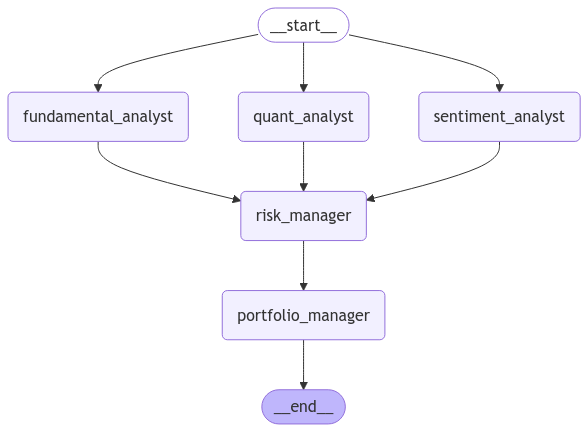

In [12]:
from IPython.display import Image, display
graph = DecisionSystem().workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))